<a href="https://colab.research.google.com/github/GaganpreetKaurKalsi/ML-CaPsule/blob/master/Sentiment-Analysis-on-IMDb-reviews/Sentiment_Analysis_on_IMDb_reviews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Sentiment Analysis on IMDb reviews 😊 😐 😔 😡**

---


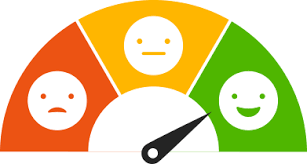

### **About the project**
In this project, instead of training on a dataset of IMDb reviews, we will fetch the latest reviews from the IMDb platform using the IMDb API and then pass it to sentiment analysis model to receive results.


<br>




## **IMDb API**

API documentation link - https://imdb-api.com/api/#Reviews-header

<br>

To work with the API, you need to first **create an API key**.
To create an API key, **register** on the site mentioned above and a unique key will be generated for you. We will use this key to make successful requests.


***Note : API call limit per day is 100***

<br>

### **API specifications**
To get reviews, we will need to make 2 API calls. 
1. Get movies based on user input. Each movie received will have a unique id.
2. Get reviews for a movie by passing the unique id associated with it received from the above API call.


**Movie API** - https://imdb-api.com/en/API/SearchMovie/{apiKey}/{movieName}    
    
**Review API** - https://imdb-api.com/en/API/Reviews/{apiKey}/{id}

<br>
<br>

## Now let's get started with our code 😎😎😎

In [1]:
baseURL = 'https://imdb-api.com/en/API'

# Enter your API key below
apiKey = ''

<br><br>

#### Importing libraries

In [2]:
# Libraries for API calls
import requests
import json

<br>
   
#### Functions to call APIs

In [3]:
# if the user is searching for the same keyword as that of last time, instead of making a new call we will return the cached data received and stored from the previous call.
lastSearched = ""
cacheData = {}

In [4]:
# Function to get movies based on user search
def getMovies(movieName):
    response = requests.get('{baseURL}/SearchMovie/{apiKey}/{movieName}'.format(baseURL=baseURL, apiKey=apiKey, movieName=movieName))
    response = response.json()
    if(isinstance(response["results"], list)):
        movies = [{"id": result['id'], "title": result['title'], "image": result["image"], "description": result["description"]} for result in response["results"]]
        return movies
    else:
        print(response["errorMessage"])
        return []

In [5]:
# Function to get reviews for individual movie ids
def getReviews(id):
    res = requests.get('{baseURL}/Reviews/{apiKey}/{id}'.format(baseURL=baseURL, apiKey=apiKey, id=id))
    res = res.json()
    if (res["errorMessage"] != ""):
        print(res["errorMessage"])
        return []
    items = res["items"]
    # Only returning 1st 20 reviews 
    if len(items)>20:
        items = items[0:20]

    # Concatenating title and content of reviews 
    reviews = [(item["title"]+" "+item["content"]) for item in items]
    return reviews

In [6]:
# Function to get movies and reviews by making API calls
# Return : A json string containing movie title, image, description, and reviews.
def getData(movieName):
    print("Sending request to get movies!!!!!!")
    movies = getMovies(movieName)
    data = []
    for movie in movies:
        reviews = getReviews(movie["id"])
        data.append({"title": movie["title"], "image": movie["image"], "description": movie["description"], "reviews": reviews})
    return json.dumps({"userSearch": movieName, "result": data})


<br><br>

We are pretty much done with collecting the reviews data. Now is the time to get sentiments out of it.

<br>
<br>

There are multiple libraries available in python for sentiment analysis. Let's see them below 👇



*   **TextBlob** - TextBlob is a Python library for processing textual data. It provides a simple API for diving into common (NLP) tasks such as part-of-speech tagging, noun phrase extraction, sentiment analysis, classification, translation, and more.
*   **Flair** - A very simple framework for state-of-the-art NLP. It is a powerful NLP library which allows you to apply state-of-the-art natural language processing (NLP) models to your text, such as named entity recognition (NER), part-of-speech tagging (PoS), etc.
*   **Vader** - VADER (Valence Aware Dictionary and Sentiment Reasoner) is a lexicon and rule-based sentiment analysis tool that is specifically attuned to sentiments expressed in social media. 
*   **text2emotion** - text2emotion is the python package which will help you to extract the emotions from the content. It processes any textual message and recognize the emotions embedded in it. It is compatible with 5 different emotion categories as Happy, Angry, Sad, Surprise and Fear.

<br>

*Note :-* 
1. textblob, flair and vader provide polarity score where text is declared in either of 3 states (POSITIVE🙂, NEGATIVE☹️, NEUTRAL😐)
2. text2emotion is the only library among the others mentioned above which can classify text in 5 emotion categories (HAPPY😊, ANGRY😡, SAD😔, SURPRISE😲, FEAR😨)



<br><br>

***LET'S BUILD THE MODALS NOW !!!***

<br><br>

## MODALS

#### TextBlob

In [7]:
from textblob import TextBlob
def textBlob(text):
    tb = TextBlob(text)
    polarity = round(tb.polarity, 2)
    if polarity>0:
        return "Positive"
    elif polarity==0:
        return "Neutral"
    else:
        return "Negative"

### Flair

In [8]:
!pip install flair
!pip install sacremoses
from flair.models import TextClassifier
from flair.data import Sentence

sia = TextClassifier.load('en-sentiment')
def flair(text):
    sentence = Sentence(text)
    sia.predict(sentence)
    score = str(sentence.labels[0])
    startIdx = int(score.rfind("("))
    endIdx = int(score.rfind(")"))
    percentage = float(score[startIdx+1:endIdx])
    if percentage < 0.60:
        return "NEUTRAL"
    elif "POSITIVE" in str(score):
        return "POSITIVE"
    elif "NEGATIVE" in str(score):
        return "NEGATIVE"

2022-05-19 13:52:21,889 loading file /root/.flair/models/sentiment-en-mix-distillbert_4.pt


### Vader

In [26]:
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

def vader(text):
    scores = SentimentIntensityAnalyzer().polarity_scores(text)
    if scores['compound'] >= 0.05 :
        return "Positive"
 
    elif scores['compound'] <= - 0.05 :
        return "Negative"
 
    else :
        return "Neutral"

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


### text2emotion

In [15]:
!pip install text2emotion
import text2emotion as te

def text2emotion(text):
    emotion = dict(te.get_emotion(text))
    # Sorting emotions in descending order of score
    emotion = sorted(emotion.items(), key =
             lambda kv:(kv[1], kv[0]), reverse=True)
    emotionStr = list(emotion)[0][0]
    if(list(emotion)[1][1]>=0.5 or list(emotion)[1][1] == list(emotion)[0][1]):
        emotionStr+="-{}".format(list(emotion)[1][0])
    return emotionStr

<br><br>

DONE WITH MODALS ✌️👍
    
Now let's write up the remaining FUNCTIONS

In [24]:
import pandas as pd
def applyModal(movie, packageName):
    if(packageName.lower() == "flair"):
        predictionList = [flair(review) for review in movie["reviews"]]
        valueCounts = dict(pd.Series(predictionList).value_counts())
        # print(valueCounts)
        return valueCounts
    elif(packageName.lower() == "textblob"):
        predictionList = [textBlob(review) for review in movie["reviews"]]
        valueCounts = dict(pd.Series(predictionList).value_counts())
        # print(valueCounts)
        return valueCounts
    elif(packageName.lower() == "vader"):
        predictionList = [vader(review) for review in movie["reviews"]]
        valueCounts = dict(pd.Series(predictionList).value_counts())
        # print("Vader : ", valueCounts)
        return valueCounts
    elif(packageName.lower() == "text2emotion"):
        predictionList = [text2emotion(review) for review in movie["reviews"]]
        valueCounts = dict(pd.Series(predictionList).value_counts())
        # print(valueCounts)
        return valueCounts
    else:
        ""

In [12]:
getEmoji = {
    "happy" : "😊",
    "neutral" : "😐",
    "sad" : "😔",
    "disgust" : "🤢",
    "surprise" : "😲",
    "fear" : "😨",
    "angry" : "😡",
    "positive": "🙂",
    "neutral": "😐",
    "negative": "☹️",
}

def getEmojiString(head):
    emojiHead = ""
    emotions = head.split("-")
    for emotion in emotions:
        emo = emotion.strip()
        emojiHead += getEmoji[emo.lower()]
    return head+" "+emojiHead

In [16]:
import matplotlib.pyplot as plt
import cv2
import numpy as np

!pip install pyyaml==5.4.1
import plotly.express as px
 

def process(movieName, packageName):
    global lastSearched, cacheData
    if(lastSearched != movieName):
        data = getData(movieName)
        lastSearched = movieName
        cacheData = data

    else:
        data = cacheData
            
    print("Result : ", json.dumps(json.loads(data)["result"], indent=4))
    # Showcasing result
    for movie in list(json.loads(data)["result"]):
        result = applyModal(movie, packageName)
        keys = list(result.keys())
        values = list(result.values())
        print("\nMovie Name : \n\t", movie["title"])
        print("\nResult : ")
        for i in range(0, len(keys)):
            print("\t", getEmojiString(keys[i]), "-" ,round(values[i], 2))

        # Graphical representation
        fig = px.pie(values=[value/len(movie["reviews"]) for value in list(result.values())], names=keys, )
        fig.show()
        # plt.pie([value/len(movie["reviews"]) for value in list(result.values())], labels = keys)
        print("\n\n\n")    

<br><br>


### Now it is finally time to get input from user and display sentiments. So let's get started 🚀

In [29]:
movieName = input("Enter a movie name for which you would like to analyze reviews : ")
print("""
Below are the libraries we use to get sentiments
1. TextBlob
2. Vader
3. Flair
4. text2emotion
""")
libraryName = input("Enter the name of library you would like to use : ")
print("")
if(libraryName.lower() in ["textblob", "vader", "flair", "text2emotion"]):
  process(movieName, libraryName)
else:
  print("Incorrect Modal Name ❌❌❌ \nTry again!!")

Enter a movie name for which you would like to analyze reviews : Avengers

Below are the libraries we use to get sentiments
1. TextBlob
2. Vader
3. Flair
4. text2emotion

Enter the name of library you would like to use : text2emotion

Result :  [
    {
        "title": "The Avengers",
        "image": "https://imdb-api.com/images/original/MV5BNDYxNjQyMjAtNTdiOS00NGYwLWFmNTAtNThmYjU5ZGI2YTI1XkEyXkFqcGdeQXVyMTMxODk2OTU@._V1_Ratio0.7273_AL_.jpg",
        "description": "(2012)",
        "reviews": [
            "The Avengers Assemble for the First Time It's a film that future generations will still be gushing about, much like previous generations did with such classics as Star Wars and Indiana Jones. It may not be perfect, but The Avengers lives up to its promise and delivers quite a punch. I feel The Avenger struggles as most superhero movies do with finding a way to naturally introduce its characters in a way that doesn't seem forced or formulaic. They do a decent job for what it is, bu






Movie Name : 
	 Avengers: Endgame

Result : 
	 Fear 😨 - 13
	 Sad 😔 - 3
	 Happy 😊 - 2
	 Surprise 😲 - 2







Movie Name : 
	 Avengers: Infinity War

Result : 
	 Surprise 😲 - 9
	 Fear 😨 - 6
	 Surprise-Sad 😲😔 - 3
	 Surprise-Happy 😲😊 - 1
	 Happy 😊 - 1







Movie Name : 
	 Avengers: Age of Ultron

Result : 
	 Fear 😨 - 11
	 Surprise 😲 - 4
	 Sad 😔 - 2
	 Sad-Fear 😔😨 - 1
	 Surprise-Fear 😲😨 - 1
	 Surprise-Sad 😲😔 - 1







Movie Name : 
	 The Toxic Avenger

Result : 
	 Fear 😨 - 8
	 Surprise 😲 - 4
	 Sad 😔 - 3
	 Happy 😊 - 2
	 Sad-Happy 😔😊 - 2
	 Surprise-Happy 😲😊 - 1
